# Loading and working with processed fetal Visium data - post cell2location deconvolution

In [1]:
import numpy as np
import scipy as sp
import scanpy as sc
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import re
import os
import scipy.stats
from numpy import asarray as ar
from collections import Counter
import anndata as ad
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # to show output from all the lines in a cells
pd.set_option('display.max_column',None) # display all the columns in pandas
pd.options.display.max_rows = 100

from datetime import date
today = str(date.today())
sc.settings.verbosity = 1
sc.logging.print_version_and_date()
%load_ext autoreload
%autoreload 2

Running Scanpy 1.10.1, on 2024-07-10 11:03.


In [2]:
## For correct plotting of the images
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import font_manager
font_manager.fontManager.addfont("/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf")
print(font_manager.findfont("Arial"))
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
sc.settings.set_figure_params(dpi = 150, color_map = 'RdPu', dpi_save = 150, vector_friendly = True, format = 'pdf')

/nfs/team205/ny1/ThymusSpatialAtlas/software/Arial.ttf


In [3]:
# output folder 
import os
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_3_nat/')
os.getcwd()

'/nfs/team205/ny1/ThymusSpatialAtlas/Figure_3_nat'

In [4]:
source_folder = '/nfs/team205/ny1/ThymusSpatialAtlas/SourceData'

# Explore gene expression and cytokine profiles  

In [5]:
adata_fet_cma = sc.read_h5ad('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_2_nat/adata_visium_rev_v1_fetal_cma_v2.h5ad')

In [6]:
adata_fet_cma.obs['annotations_level_1'].value_counts()

annotations_level_1
unassigned    9967
PVS            109
HC               3
Name: count, dtype: int64

# correlations with axis 

Capsular= (-0.75>cma_v2)
Sub-Capsular= (-0.75<=cma_v2) & (-0.62>cma_v2)
Cortical level 1= (-0.62<=cma_v2) & (-0.55>cma_v2)
Cortical level 2= (-0.55<=cma_v2) & (-0.45>cma_v2)
Cortical level 3= (-0.45<=cma_v2) & (-0.3>cma_v2)
Cortical CMJ= (-0.3<=cma_v2) & (0.1>cma_v2)
Medullar CMJ= (0.1<=cma_v2) & (0.55>cma_v2)
Medullar level 1= (0.55<=cma_v2) & (0.65>cma_v2)
Medullar level 2= (0.65<=cma_v2) & (0.7>cma_v2)
Medullar level 3= (0.7=<cma_v2)


manual_bin_cma_v2
Cortical level 2    1623
Capsular            1521
Cortical level 1    1346
Cortical level 3    1141
Medullar CMJ        1139
Medullar level 1     943
Cortical CMJ         912
Medullar level 2     612
Sub-Capsular         506
Medullar level 3     336
Name: count, dtype: int64

<Axes: >

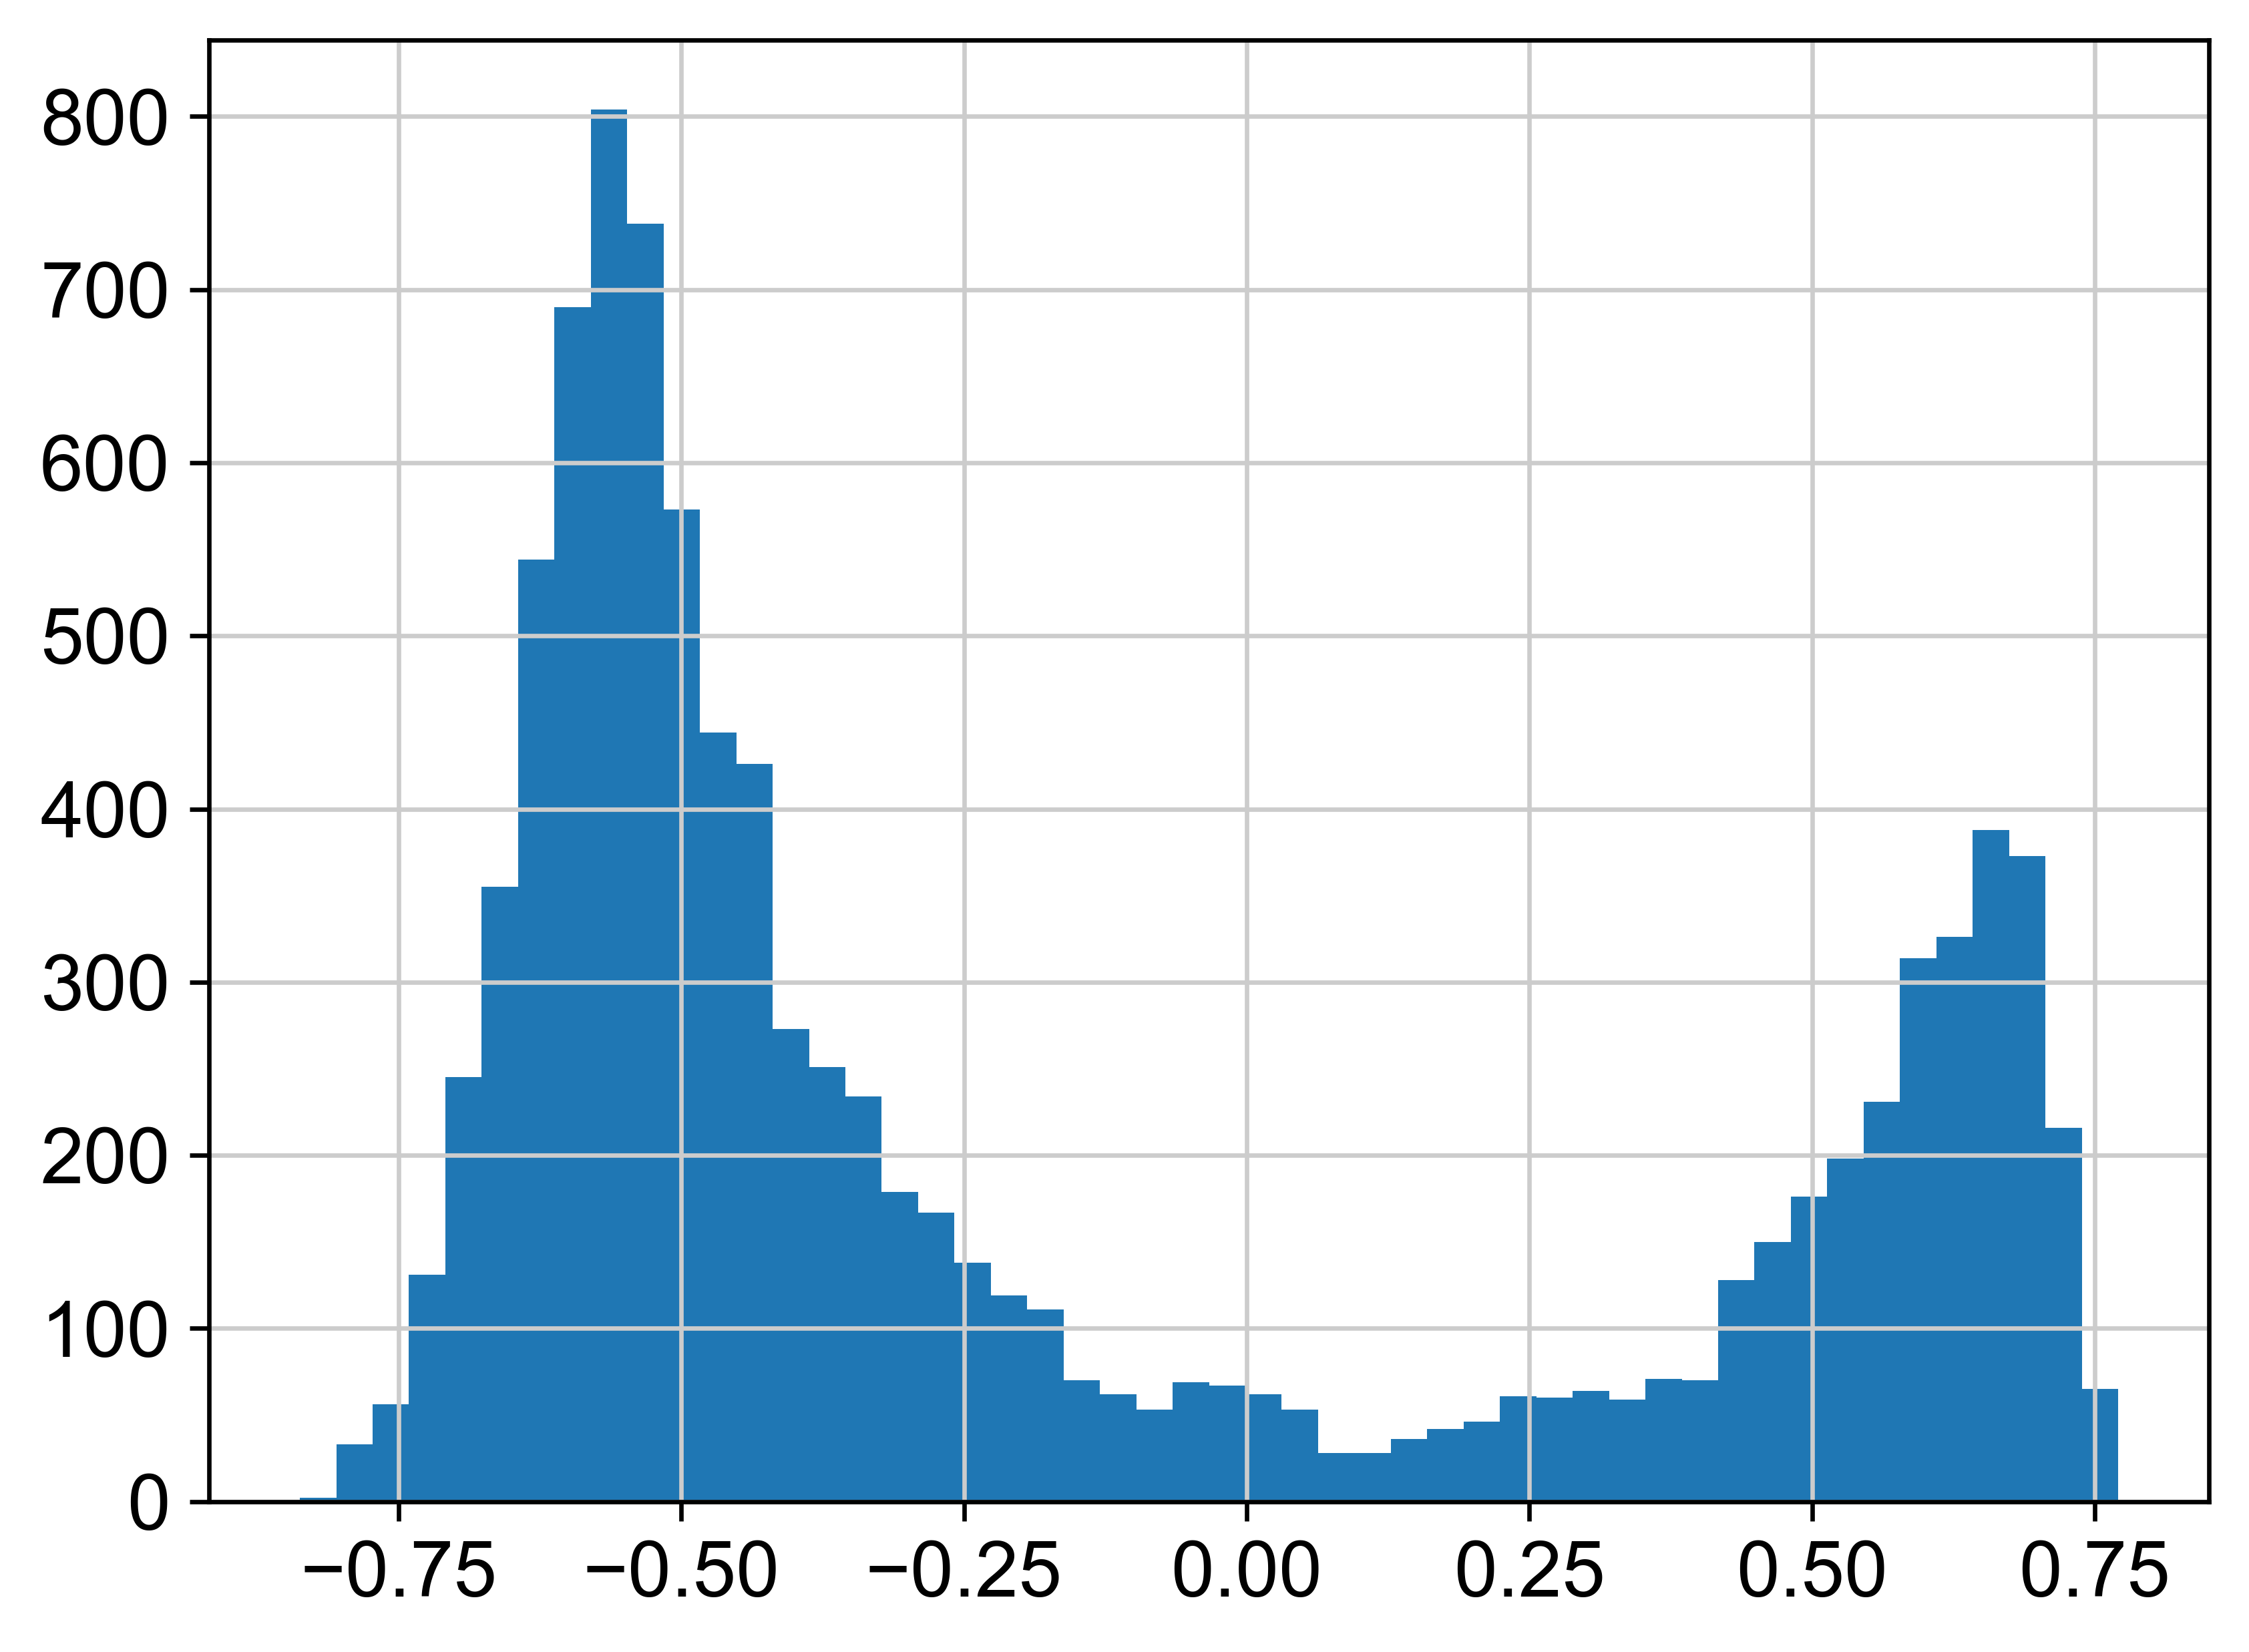

In [7]:
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/software/ImageSpot/')
import imagespot_rev_v1 as ims
import seaborn as sns
ct_order = ['Capsular','Sub-Capsular','Cortical level 1','Cortical level 2','Cortical level 3','Cortical CMJ','Medullar CMJ','Medullar level 1','Medullar level 2','Medullar level 3']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette("tab20", len(ct_order)))[range(len(ct_order))]))
ct2_values = [-0.75,-0.62,-0.55,-0.45,-0.3,0.1,0.55,0.65,0.7]
adata_fet_cma.obs = ims.bin_axis(ct_order ,ct2_values,adata_fet_cma.obs,'cma_v2')   
adata_fet_cma.obs.loc[adata_fet_cma.obs['annotations_level_0']=='Edge','manual_bin_cma_v2'] = 'Capsular'
adata_fet_cma.obs['manual_bin_cma_v2'] = adata_fet_cma.obs['manual_bin_cma_v2'].cat.reorder_categories(ct_order)
adata_fet_cma.obs['manual_bin_cma_v2'].value_counts()
adata_fet_cma.obs['cma_v2'].hist(bins=50)
plt.show()

# Analyse cell level

In [8]:
celltypes = adata_fet_cma.uns['mod']['factor_names']
cellab_fet = sc.AnnData(adata_fet_cma.obs[celltypes], 
                         obs = adata_fet_cma.obs.drop(celltypes, axis = 1),obsm = adata_fet_cma.obsm)
 
cellab_fet.var_names
sc.pp.normalize_total(cellab_fet,target_sum=100)
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_3_nat/')


Index(['B-Prolif', 'B-memory', 'B-naive', 'DC1', 'DC1-Prolif', 'DC2',
       'DC2-Prolif', 'EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif',
       'EC-Lymphatic', 'EC-Ven', 'EC-Ven-ELN', 'GMP', 'InterloFb',
       'InterloFb-COL9A3', 'Macrophage-APOC2', 'Macrophage-LYVE1',
       'Macrophage-SPIC1', 'Mast', 'Mesothelium', 'Monocyte_IL1B', 'Pericyte',
       'Pericyte_CCL19', 'Pericyte_COL1A1', 'PeriloFb', 'PeriloFb-Prolif',
       'ProlifPericyte', 'Promonocyte', 'RBC', 'SMC', 'Schwann',
       'TEC-cilliated', 'TEC-myo', 'TEC-neuro', 'TEC-tuft', 'T_CD4', 'T_CD8',
       'T_CD8-Prolif', 'T_CD8αα(I)', 'T_CD8αα(II)', 'T_CD8αα(entry)',
       'T_DN(P)', 'T_DN(Q)', 'T_DN(early)', 'T_DP(P)', 'T_DP(Q)',
       'T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj', 'T_ETP', 'T_NK',
       'T_NK_fetal', 'T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2',
       'T_Treg_mature', 'T_Treg_recirc', 'T_cycling', 'T_innate_type_1',
       'T_innate_type_3', 'T_αβT(entry)', 'T_γδT', 'aDC1', 'aDC3', 

In [9]:
cells = {'CD8aa': [ 'T_CD8αα(entry)','T_CD8αα(I)', 'T_CD8αα(II)'],
         'DP':['T_DP(P)', 'T_DP(Q)','T_DP(Q)-CD99', 'T_DP(Q)-early', 'T_DP(Q)-late_vdj'],
         'DP_other':['T_DP(Q)-CD99','T_DP(Q)-late_vdj'],
         'SP_other':['T_CD8-Prolif','T_cycling'],
         'Treg':['T_Treg(agonist)', 'T_Treg-diff_1', 'T_Treg-diff_2','T_Treg_mature', 'T_Treg_recirc',],
         'DN':['T_ETP', 'T_DN(early)', 'T_DN(P)', 'T_DN(Q)'],
         'innate':[ 'T_γδT','T_NK'], # rename nk fetal to T_SP_fetal_ambigouous
         'B': ['small_pre_B','pro_B','late_pro_B','B-Prolif', 'B-memory', 'B-naive',],
         'DC': ['pDC', 'DC1-Prolif','DC1','aDC1', 'DC2-Prolif','DC2', 'aDC3'],
         'EC': ['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif', 'EC-Ven', 'EC-Ven-ELN','EC-Lymphatic',],
         'FB':['PeriloFb', 'PeriloFb-Prolif','InterloFb','InterloFb-COL9A3', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh'],
         'pericyte':['Pericyte','Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte','SMC'],
         'other':['GMP','Mast', 'Mesothelium', 'Monocyte_IL1B', 'Promonocyte', 'RBC', 'SMC', 'Schwann','nmSchwann',],
         'mono':[ 'Monocyte_IL1B', 'Promonocyte','Mast', 'RBC'],
         'MAC':['Macrophage-APOC2', 'Macrophage-LYVE1','Macrophage-SPIC1',],
         'Early':['T_ETP', 'T_DN(early)'],
         'TEC_fig4':['cTECII','cTECI','mcTEC-Prolif','mcTEC',  'mTECI', 'mTECII', 'mTECIII',],
         'TEC_special':['mTECI-trans','TEC-myo', 'TEC-neuro','TEC-cilliated', ],
         'T_traj':['T_DN(P)', 'T_DN(Q)','T_DP(P)','T_DP(Q)-early','T_DP(Q)','T_αβT(entry)', 'T_CD4', 'T_CD8']
        }


In [10]:
def export_Source_dotplot (Dotplot_obj, path, name):
    title1 = pd.DataFrame(['Cell type abundance'], columns=['Title'])
    df1 = Dotplot_obj.dot_color_df
    title2 = pd.DataFrame(['Cell type proportion'], columns=['Title'])
    df2 = Dotplot_obj.dot_size_df
    # Create an Excel writer object
    with pd.ExcelWriter(f'{path}/{name}.xlsx', engine='openpyxl') as writer:
        # Write the first title
        title1.to_excel(writer, index=False, header=False, startrow=0, sheet_name='Sheet1')
        # Write the first dataframe
        df1.to_excel(writer, startrow=1, sheet_name='Sheet1')
        # Calculate the row to start the second title
        startrow = len(df1) + 3  # Adding 4 rows for spacer and title
        # Write the second title
        title2.to_excel(writer, index=False, header=False, startrow=startrow, sheet_name='Sheet1')
        # Write the second dataframe
        df2.to_excel(writer, startrow=startrow+1, sheet_name='Sheet1')
        print (f'{path}/{name}.xlsx has been written')

DC
['pDC', 'DC1-Prolif', 'DC1', 'aDC1', 'DC2-Prolif', 'DC2', 'aDC3']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/DC_0.25_fetal_Visdotplot_source_data.xlsx has been written


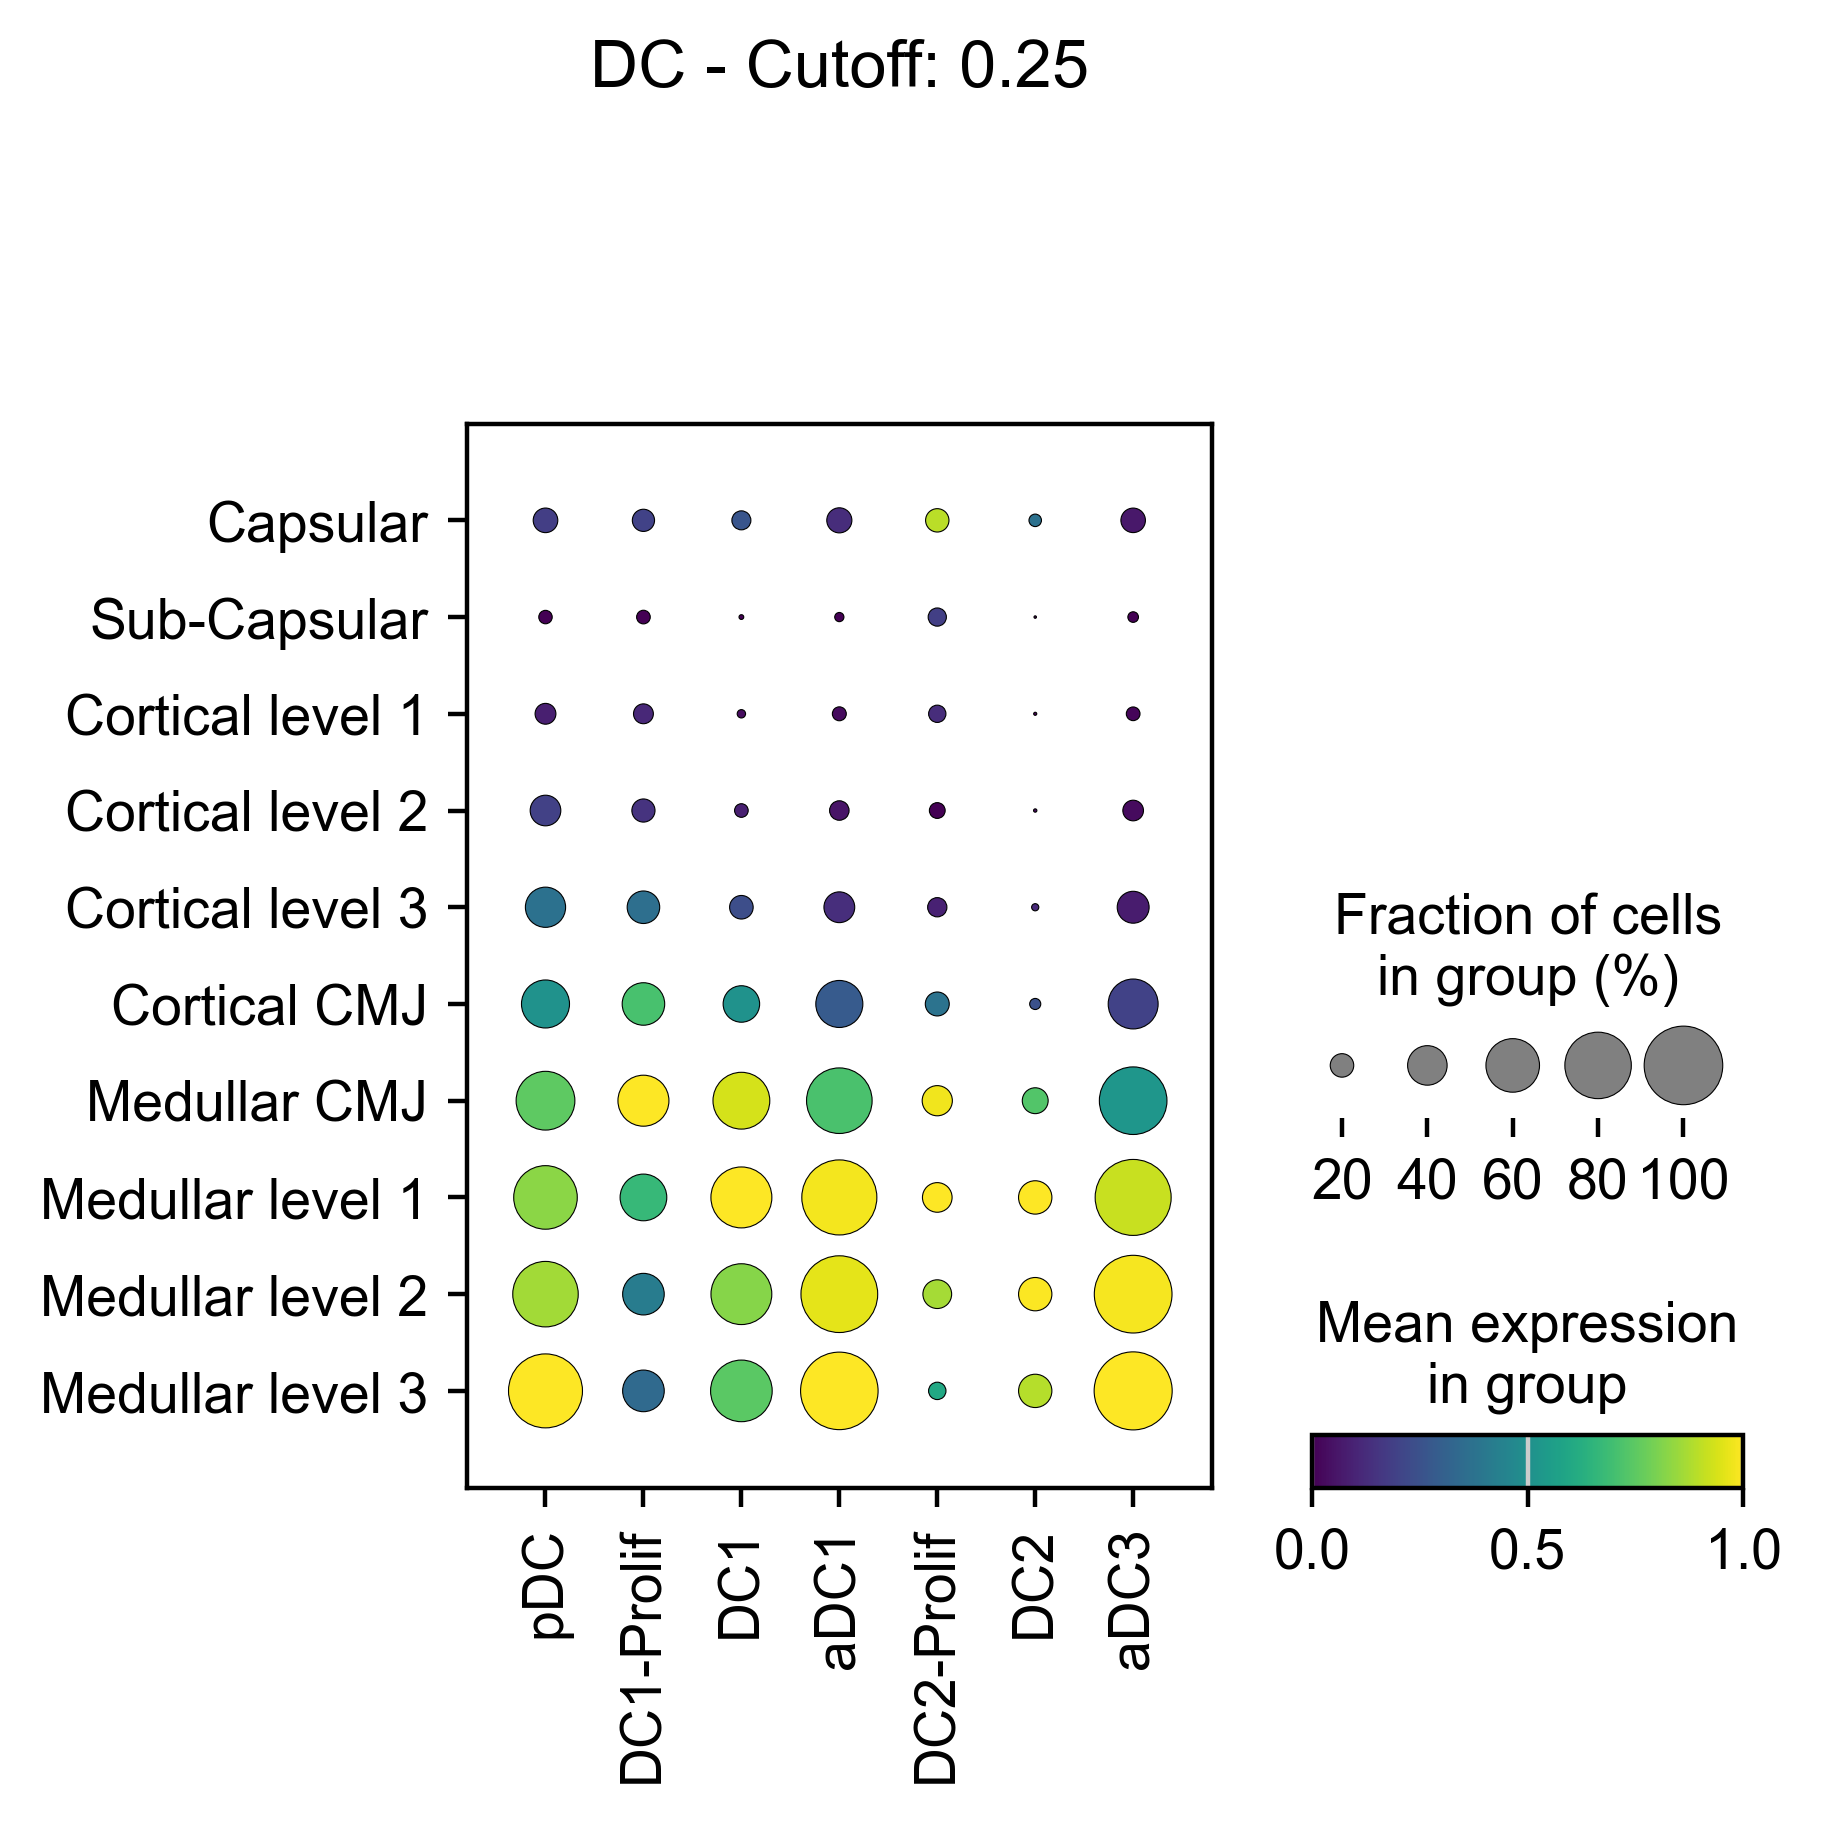

MAC
['Macrophage-APOC2', 'Macrophage-LYVE1', 'Macrophage-SPIC1']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/MAC_0.25_fetal_Visdotplot_source_data.xlsx has been written


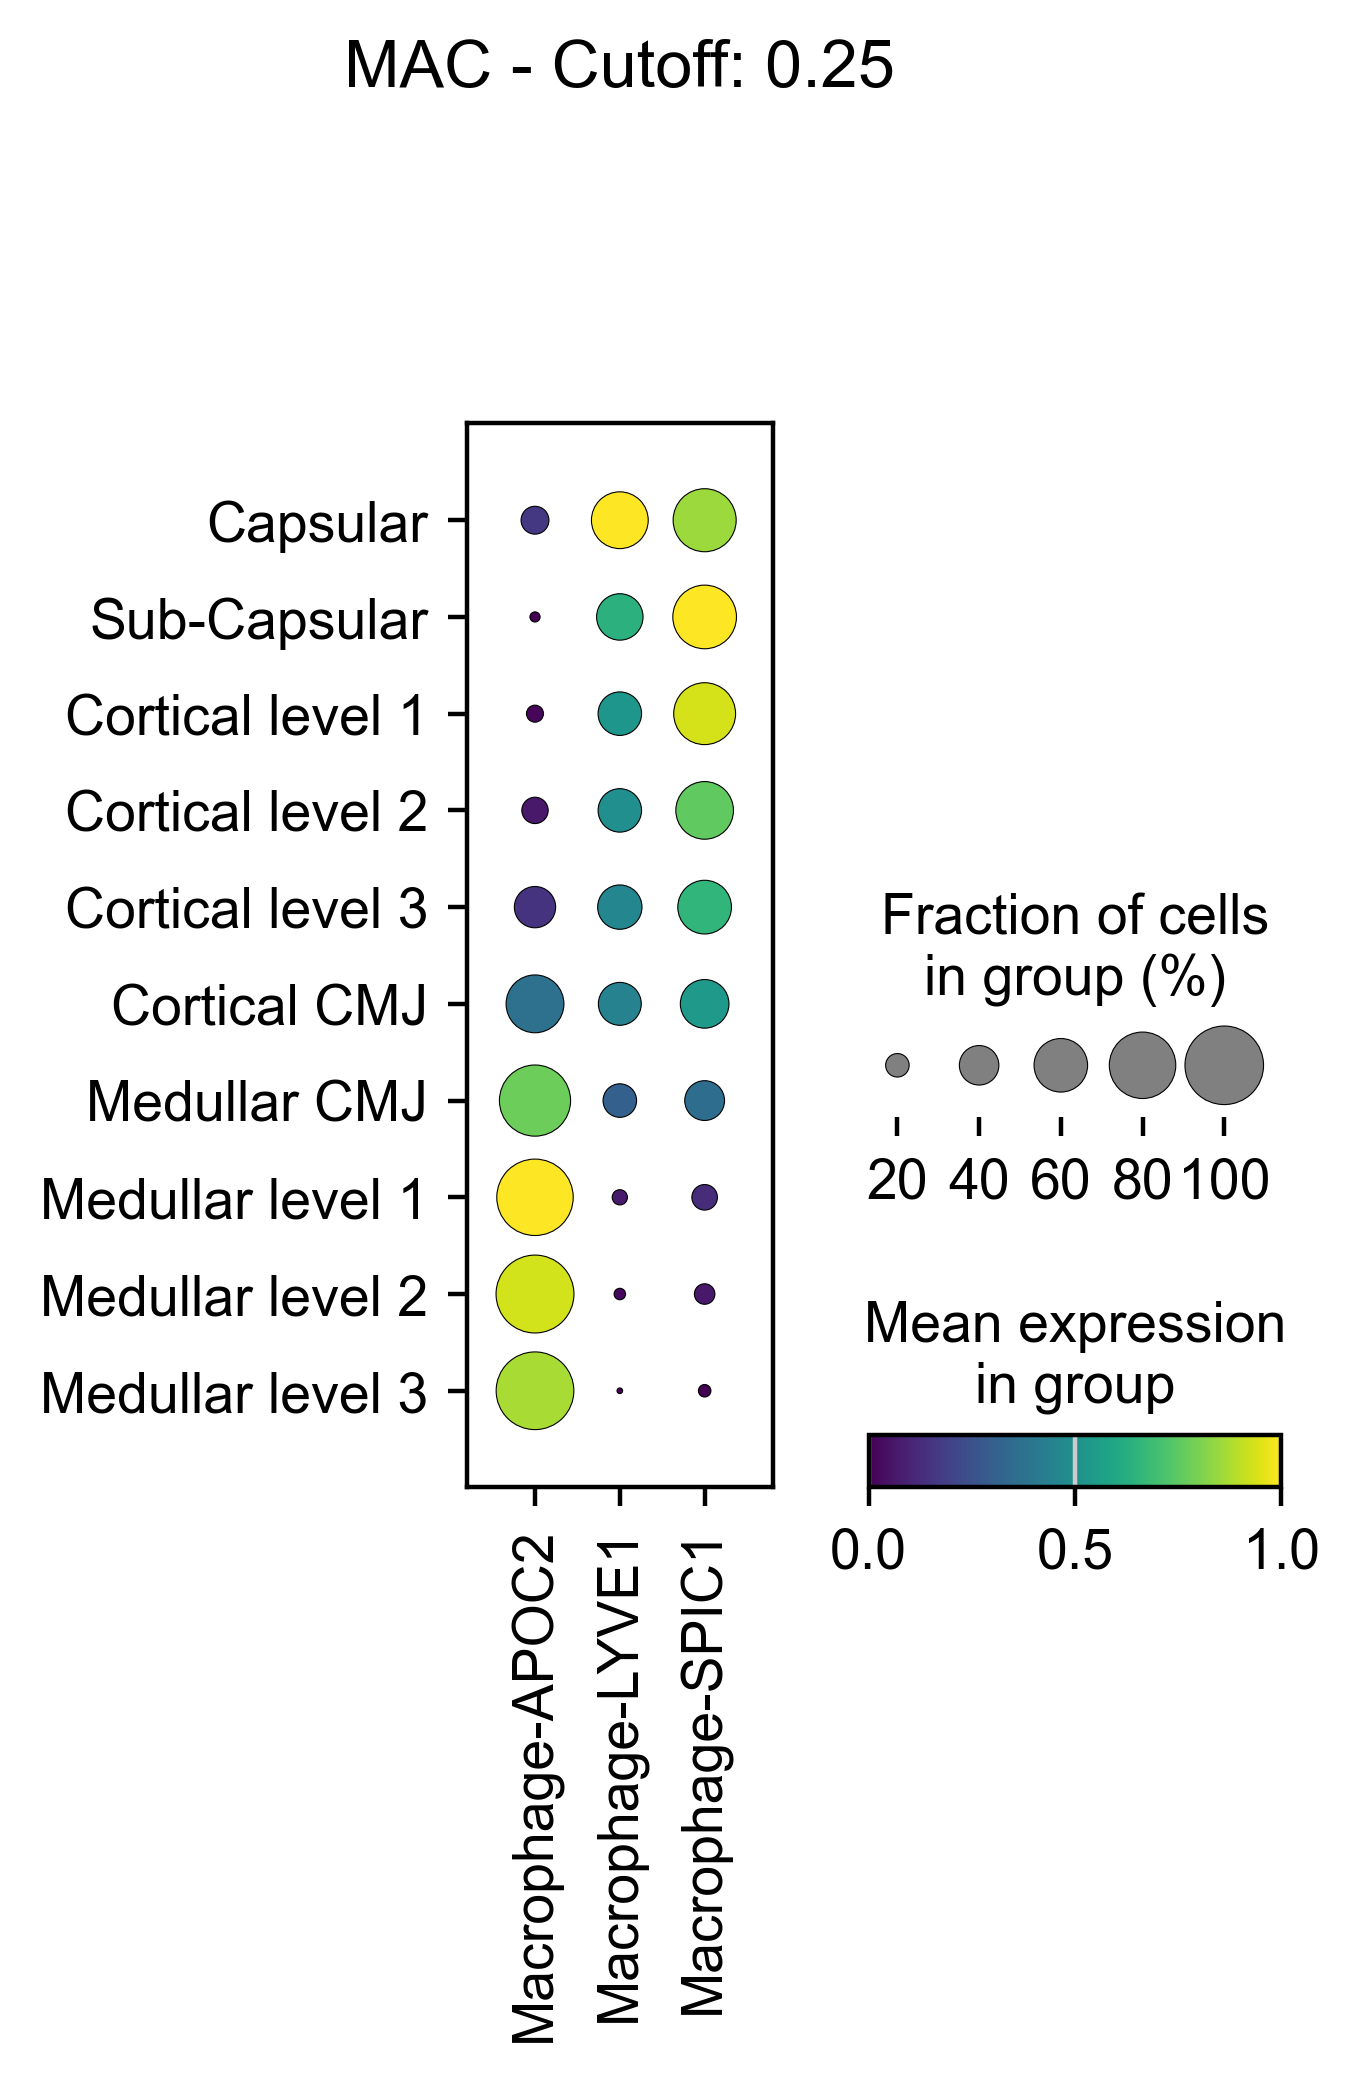

B
['small_pre_B', 'pro_B', 'late_pro_B', 'B-Prolif', 'B-memory', 'B-naive']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/B_0.5_fetal_Visdotplot_source_data.xlsx has been written


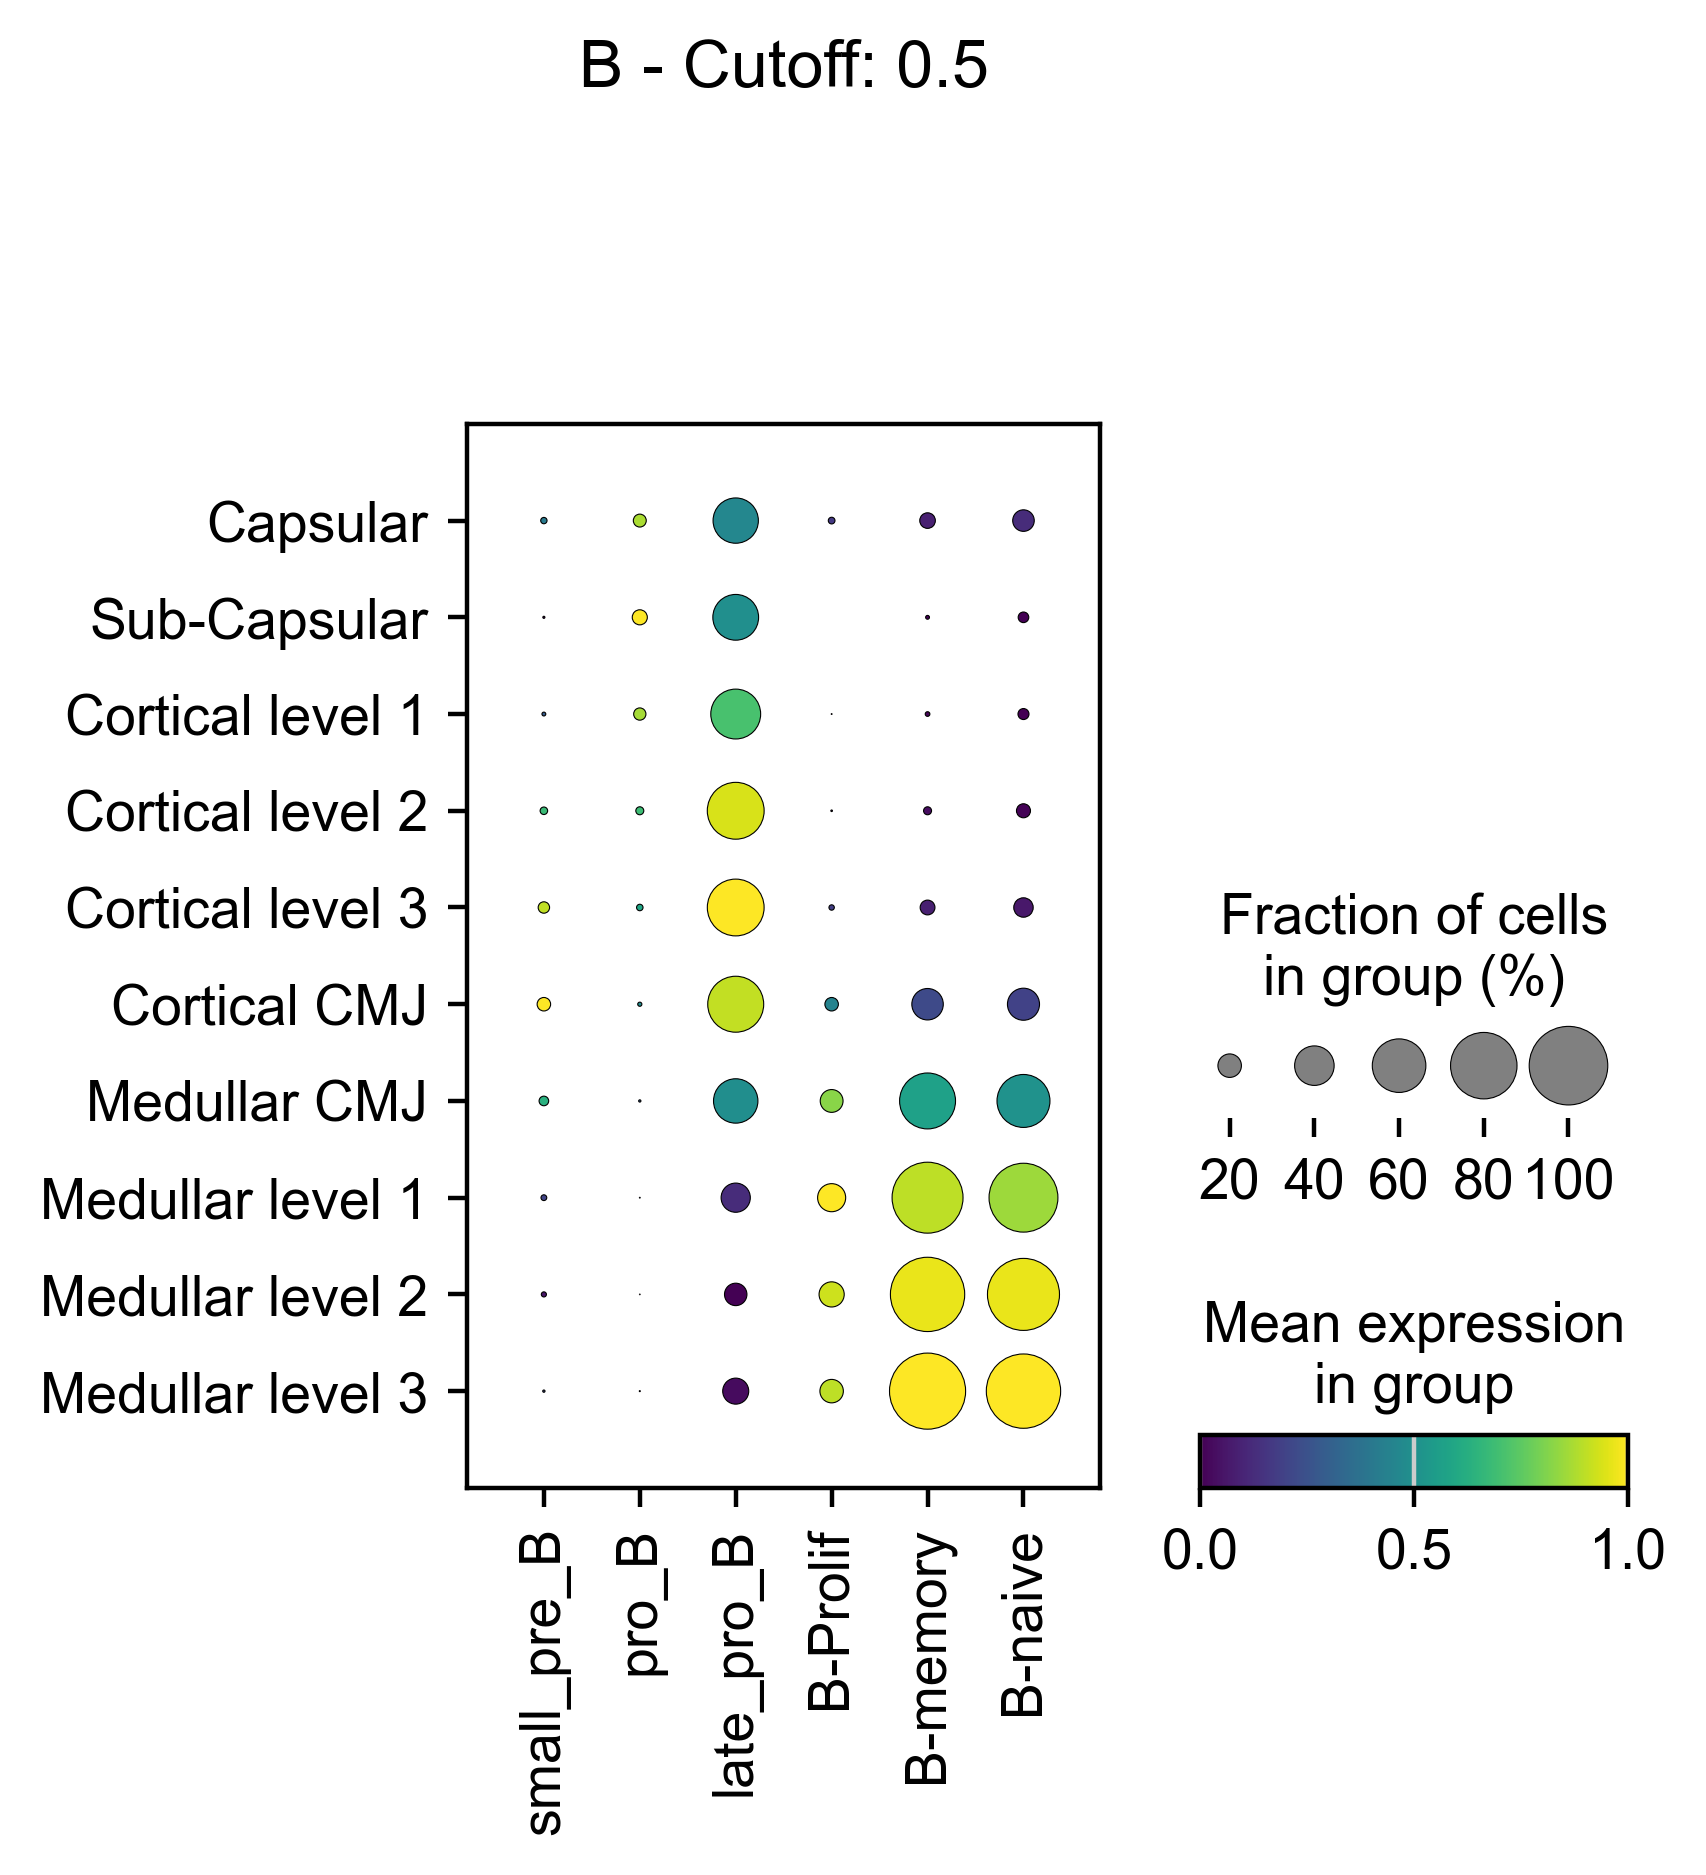

mono
['Monocyte_IL1B', 'Promonocyte', 'Mast', 'RBC']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/mono_0.1_fetal_Visdotplot_source_data.xlsx has been written


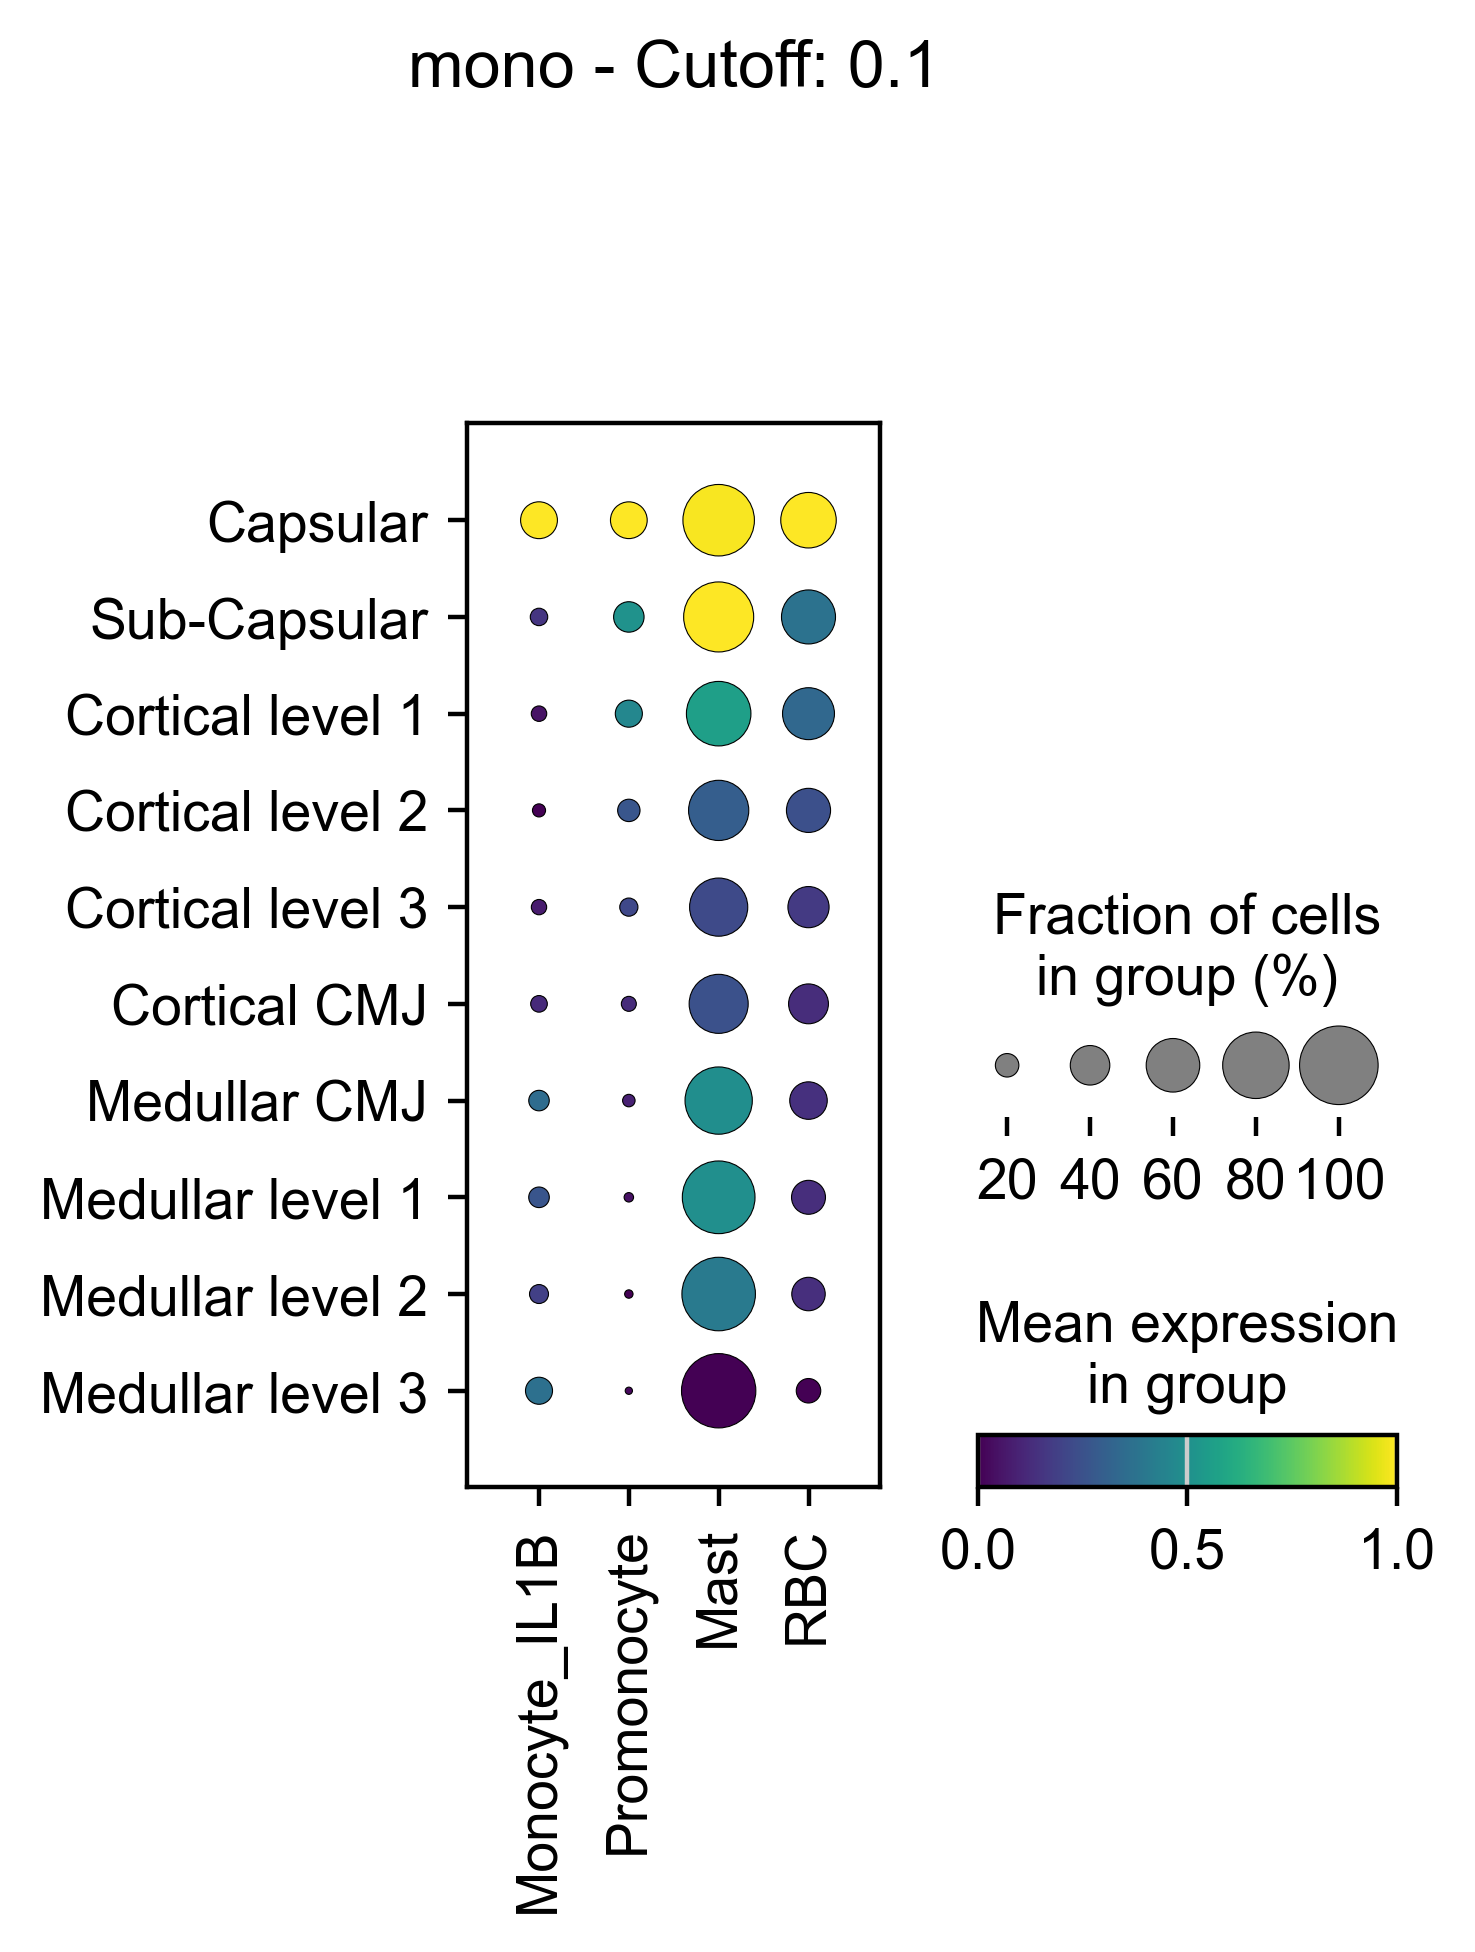

In [15]:
# subset cells supplemnetary myloid figure 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_3_nat/')

subset_keys = ['DC','MAC','B','mono']
cutoff = {'DC':0.25,'MAC':0.25,'B':0.5,'mono':0.1}
cells_subset = {k: cells[k] for k in subset_keys}
 
sc.set_figure_params(figsize=[7, 7], fontsize=12, dpi=200)

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = f'fet_{cell}_cutoff_{cutoff[cell]}.pdf'  # Construct the file name
    dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
              groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                      expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True)#save=save_path)
    export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff[cell]}_fetal_Visdotplot_source_data")
    dp.show()
    

FB
['PeriloFb', 'PeriloFb-Prolif', 'InterloFb', 'InterloFb-COL9A3', 'medFb', 'medFb-RGS5', 'medFB-MHCIIh']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/FB_0.15_fetal_Visdotplot_source_data.xlsx has been written


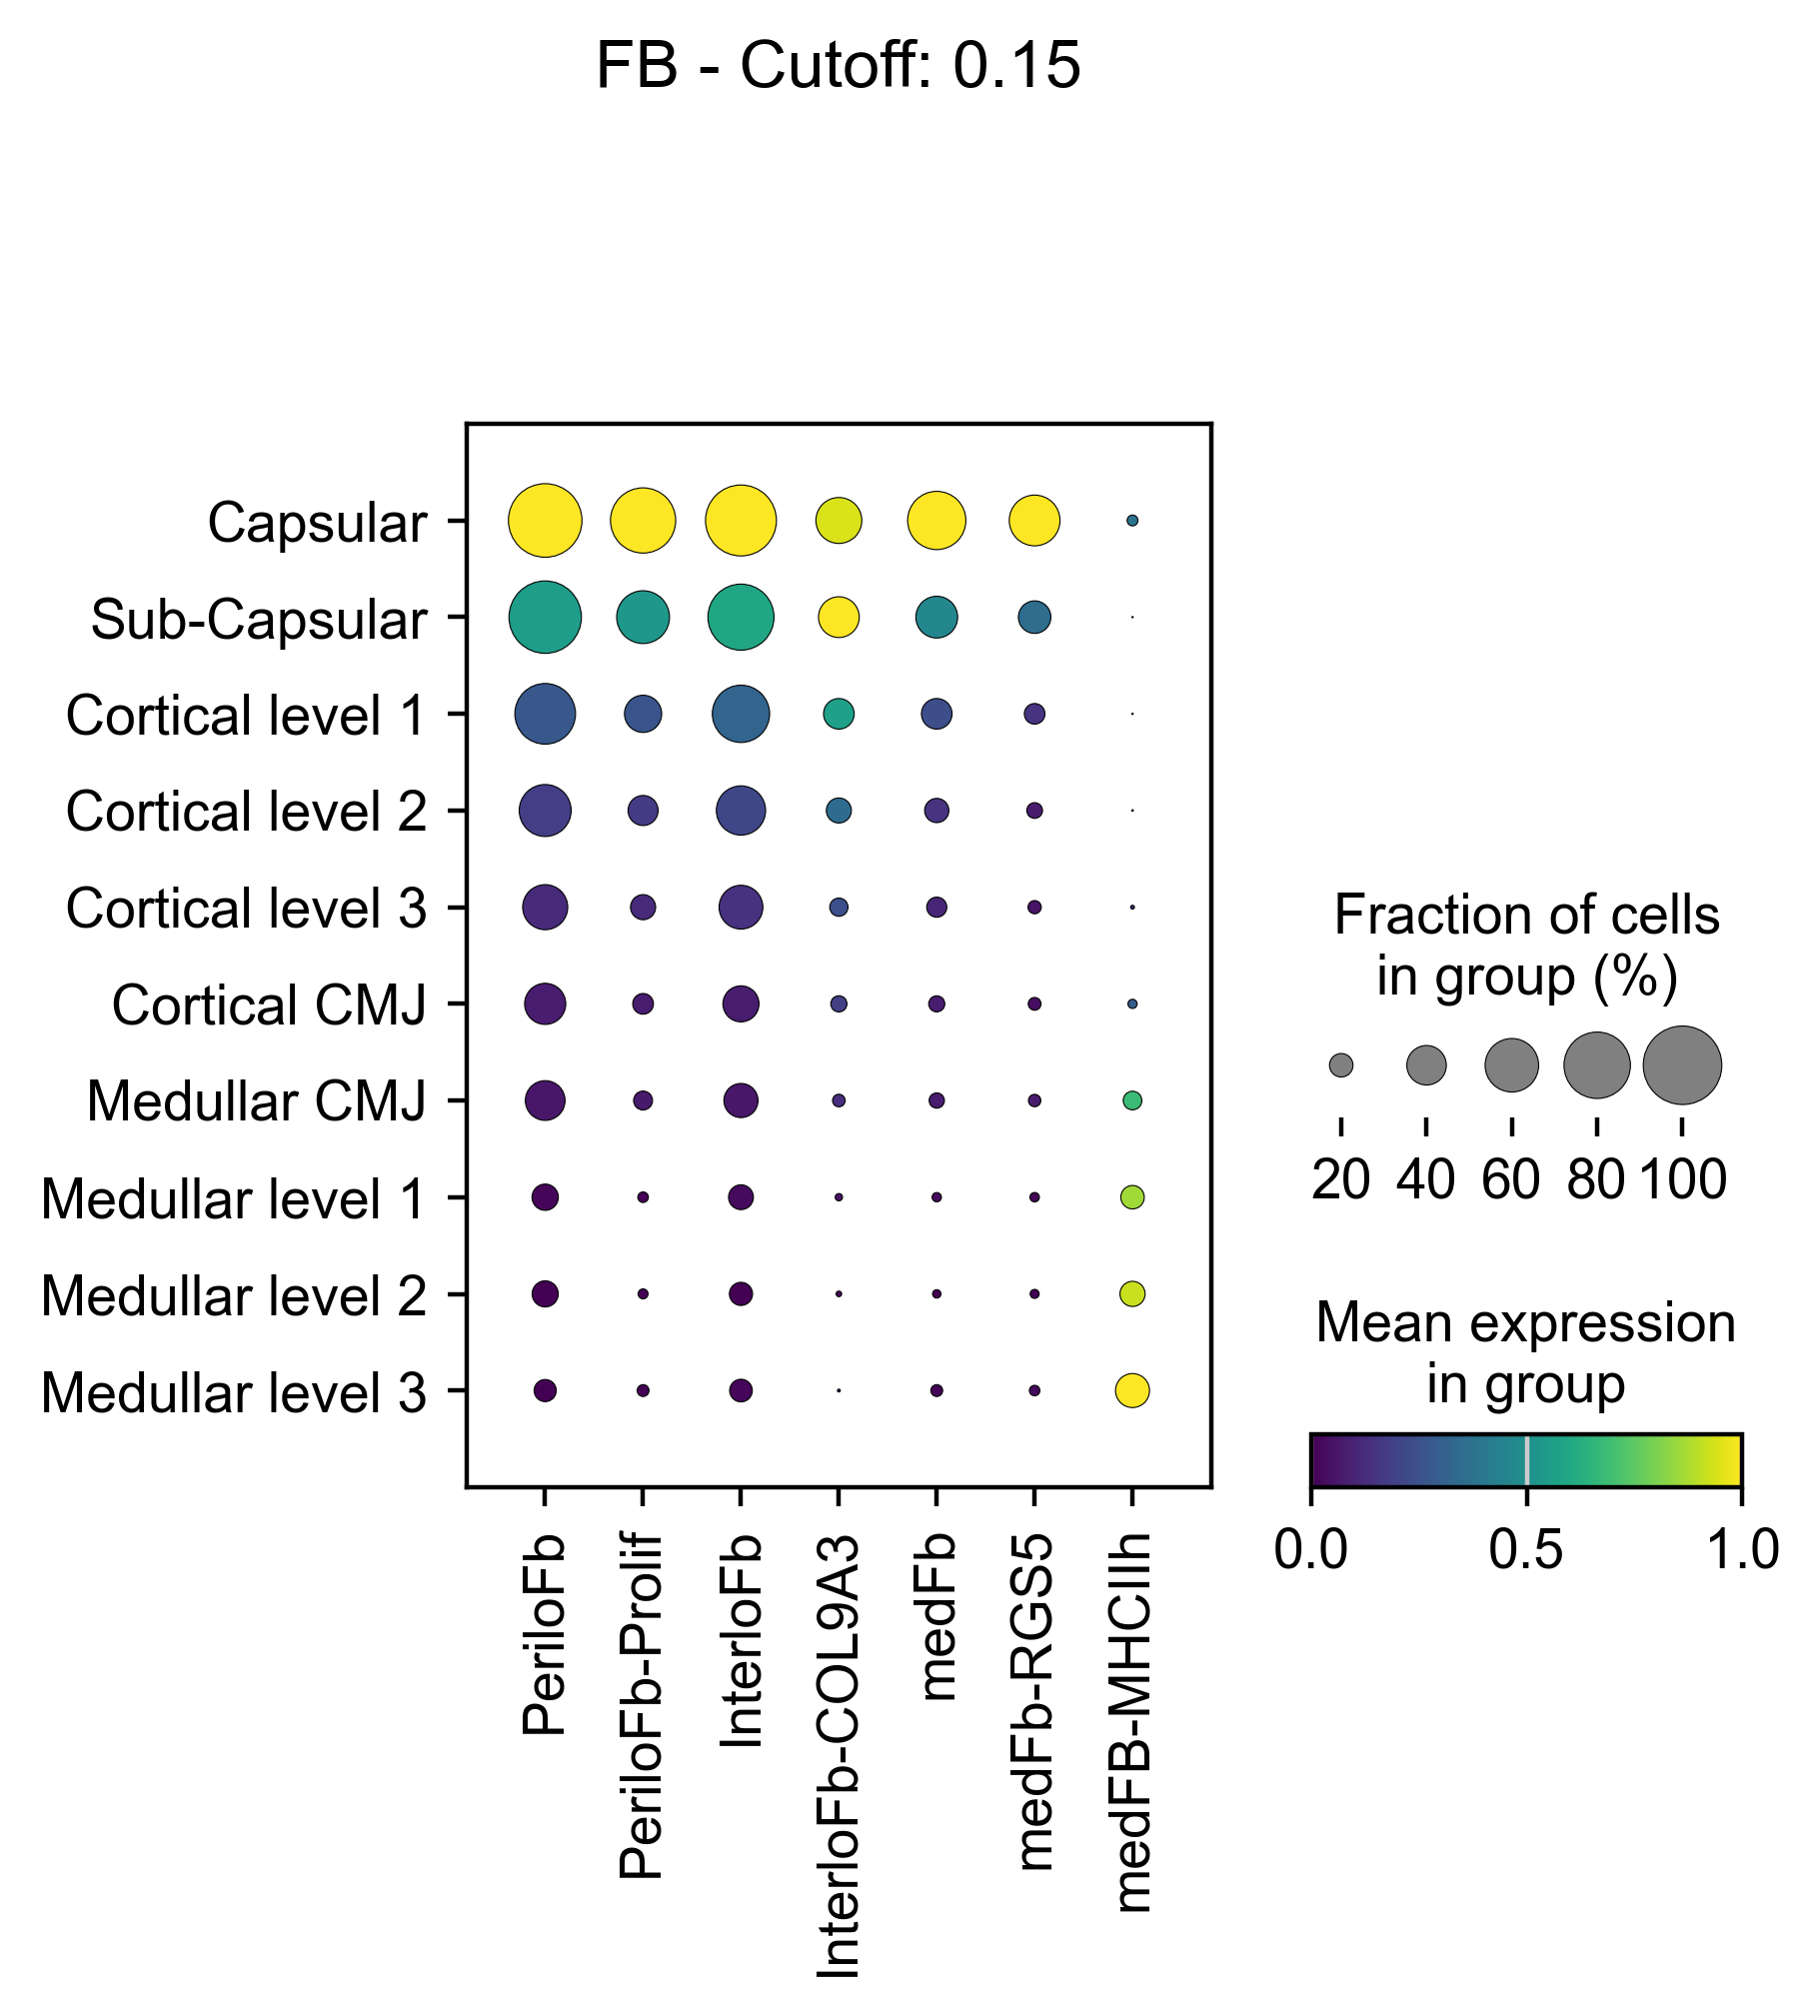

EC
['EC-Art', 'EC-Art-ELN', 'EC-Cap', 'EC-Cap-Prolif', 'EC-Ven', 'EC-Ven-ELN', 'EC-Lymphatic']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/EC_0.15_fetal_Visdotplot_source_data.xlsx has been written


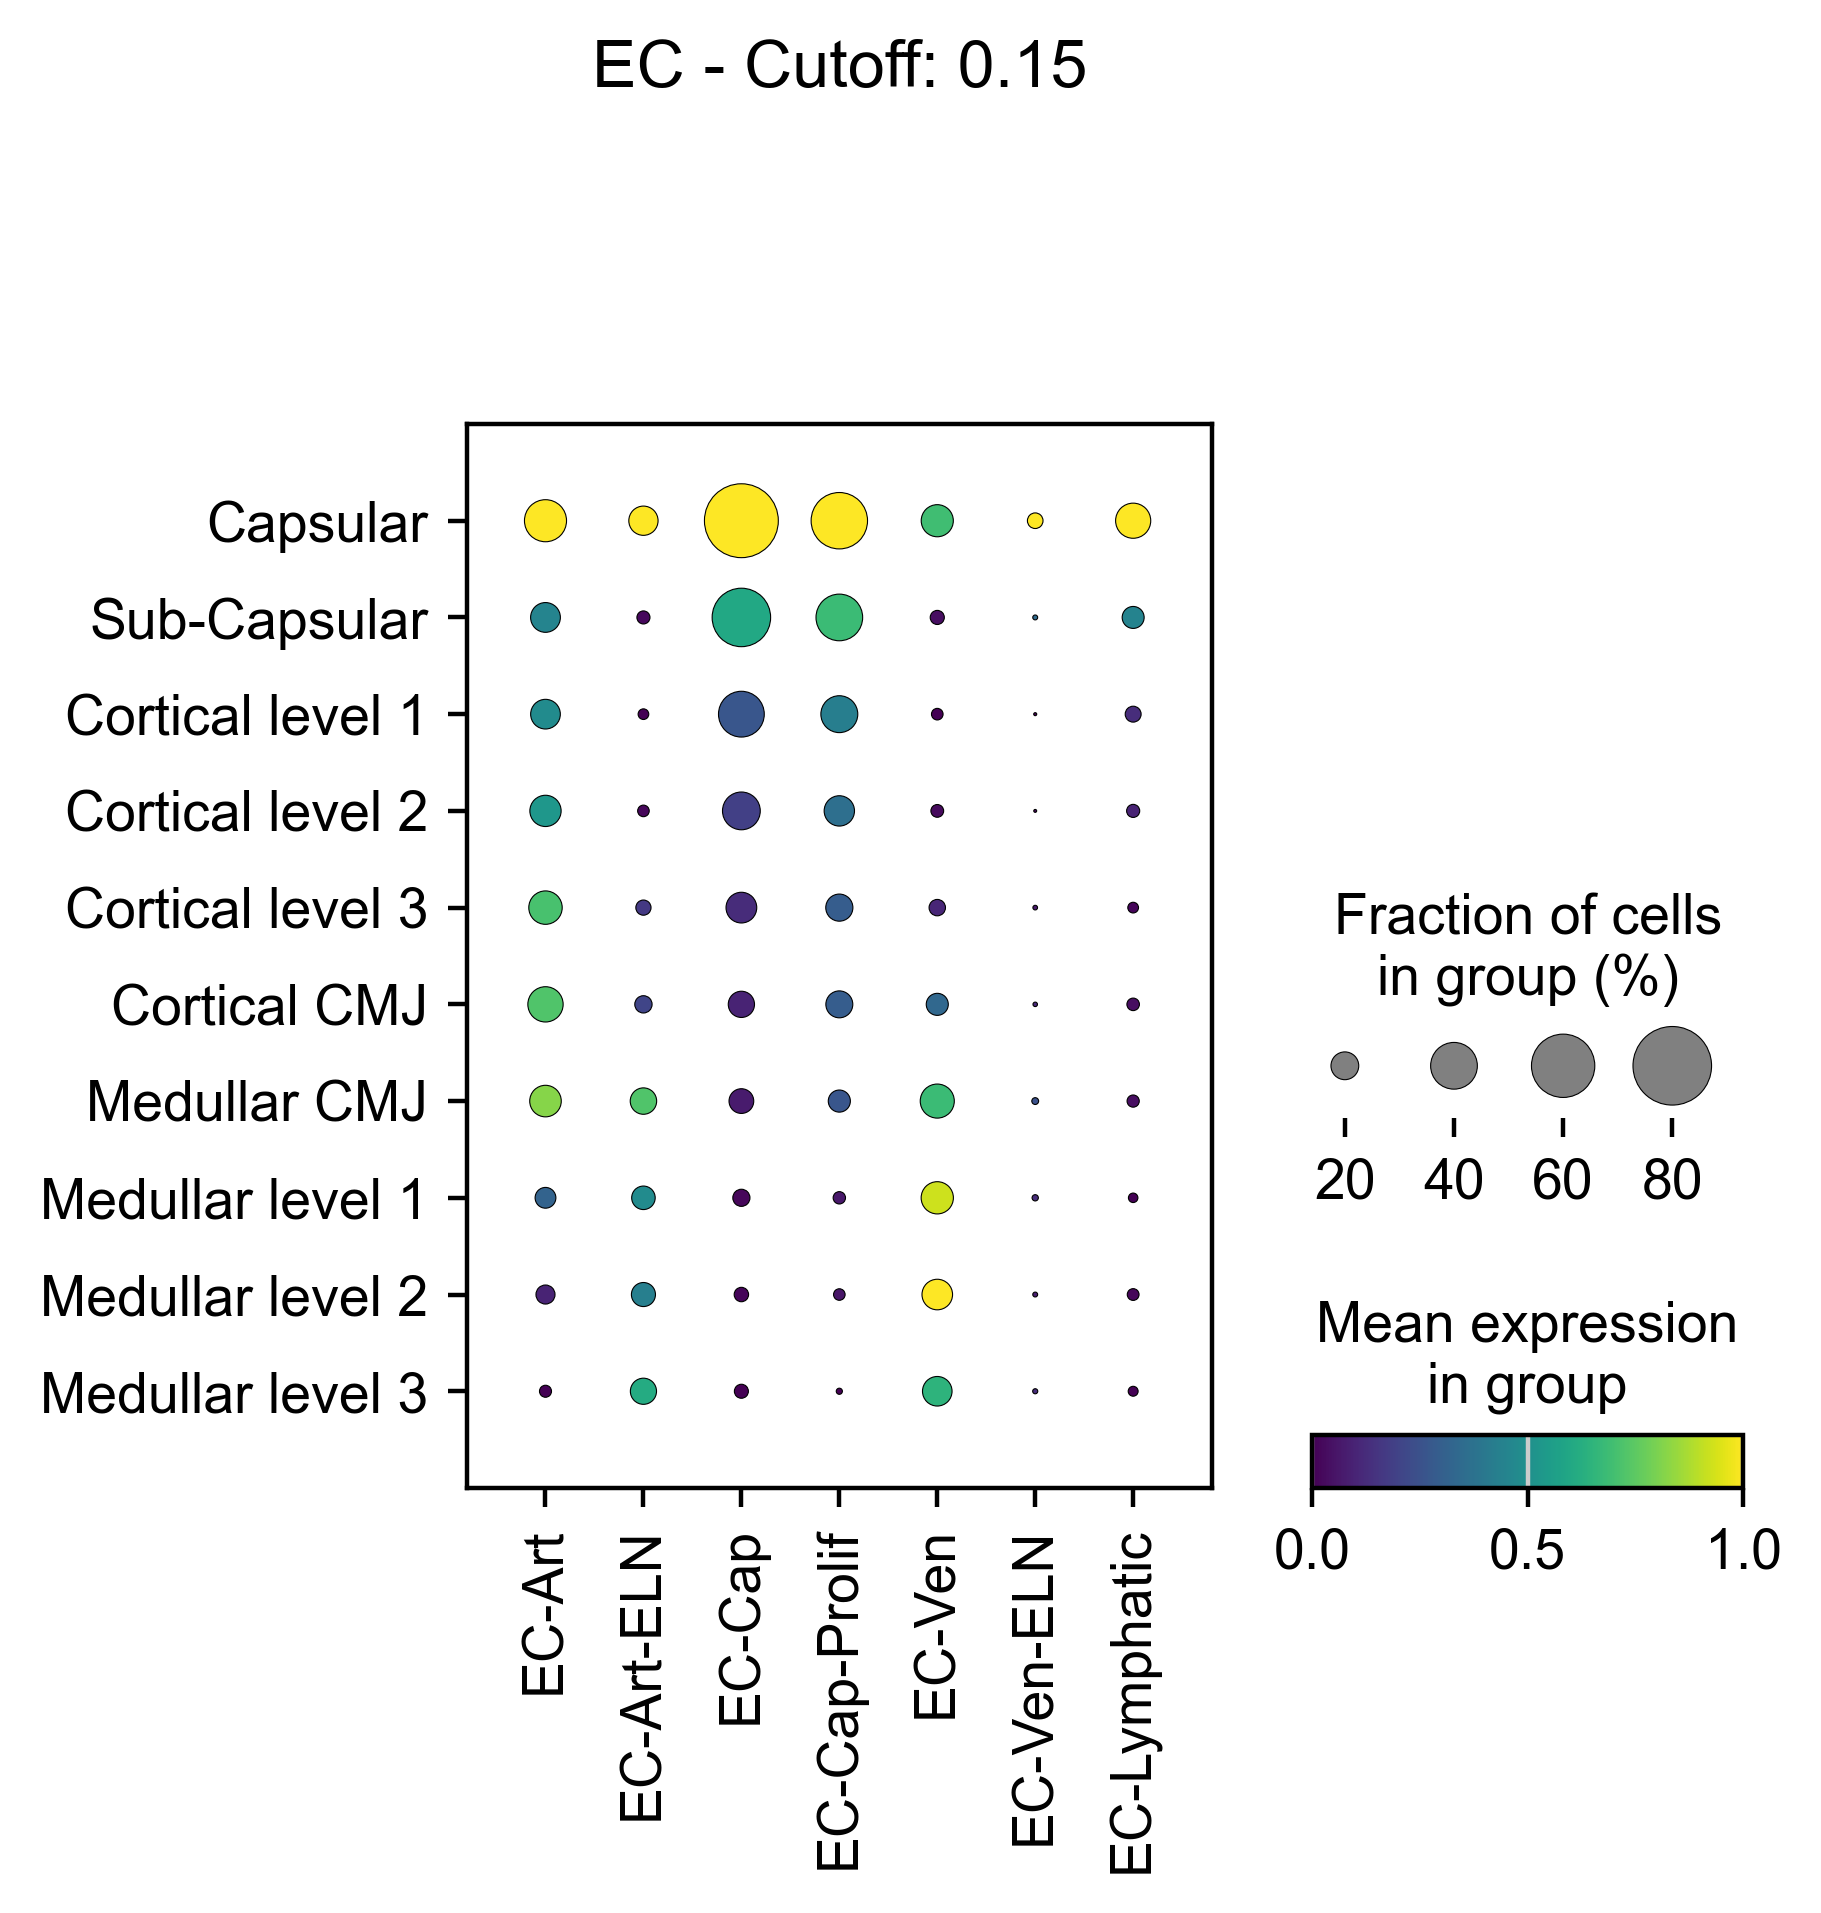

pericyte
['Pericyte', 'Pericyte_CCL19', 'Pericyte_COL1A1', 'ProlifPericyte', 'SMC']
/nfs/team205/ny1/ThymusSpatialAtlas/SourceData/pericyte_0.15_fetal_Visdotplot_source_data.xlsx has been written


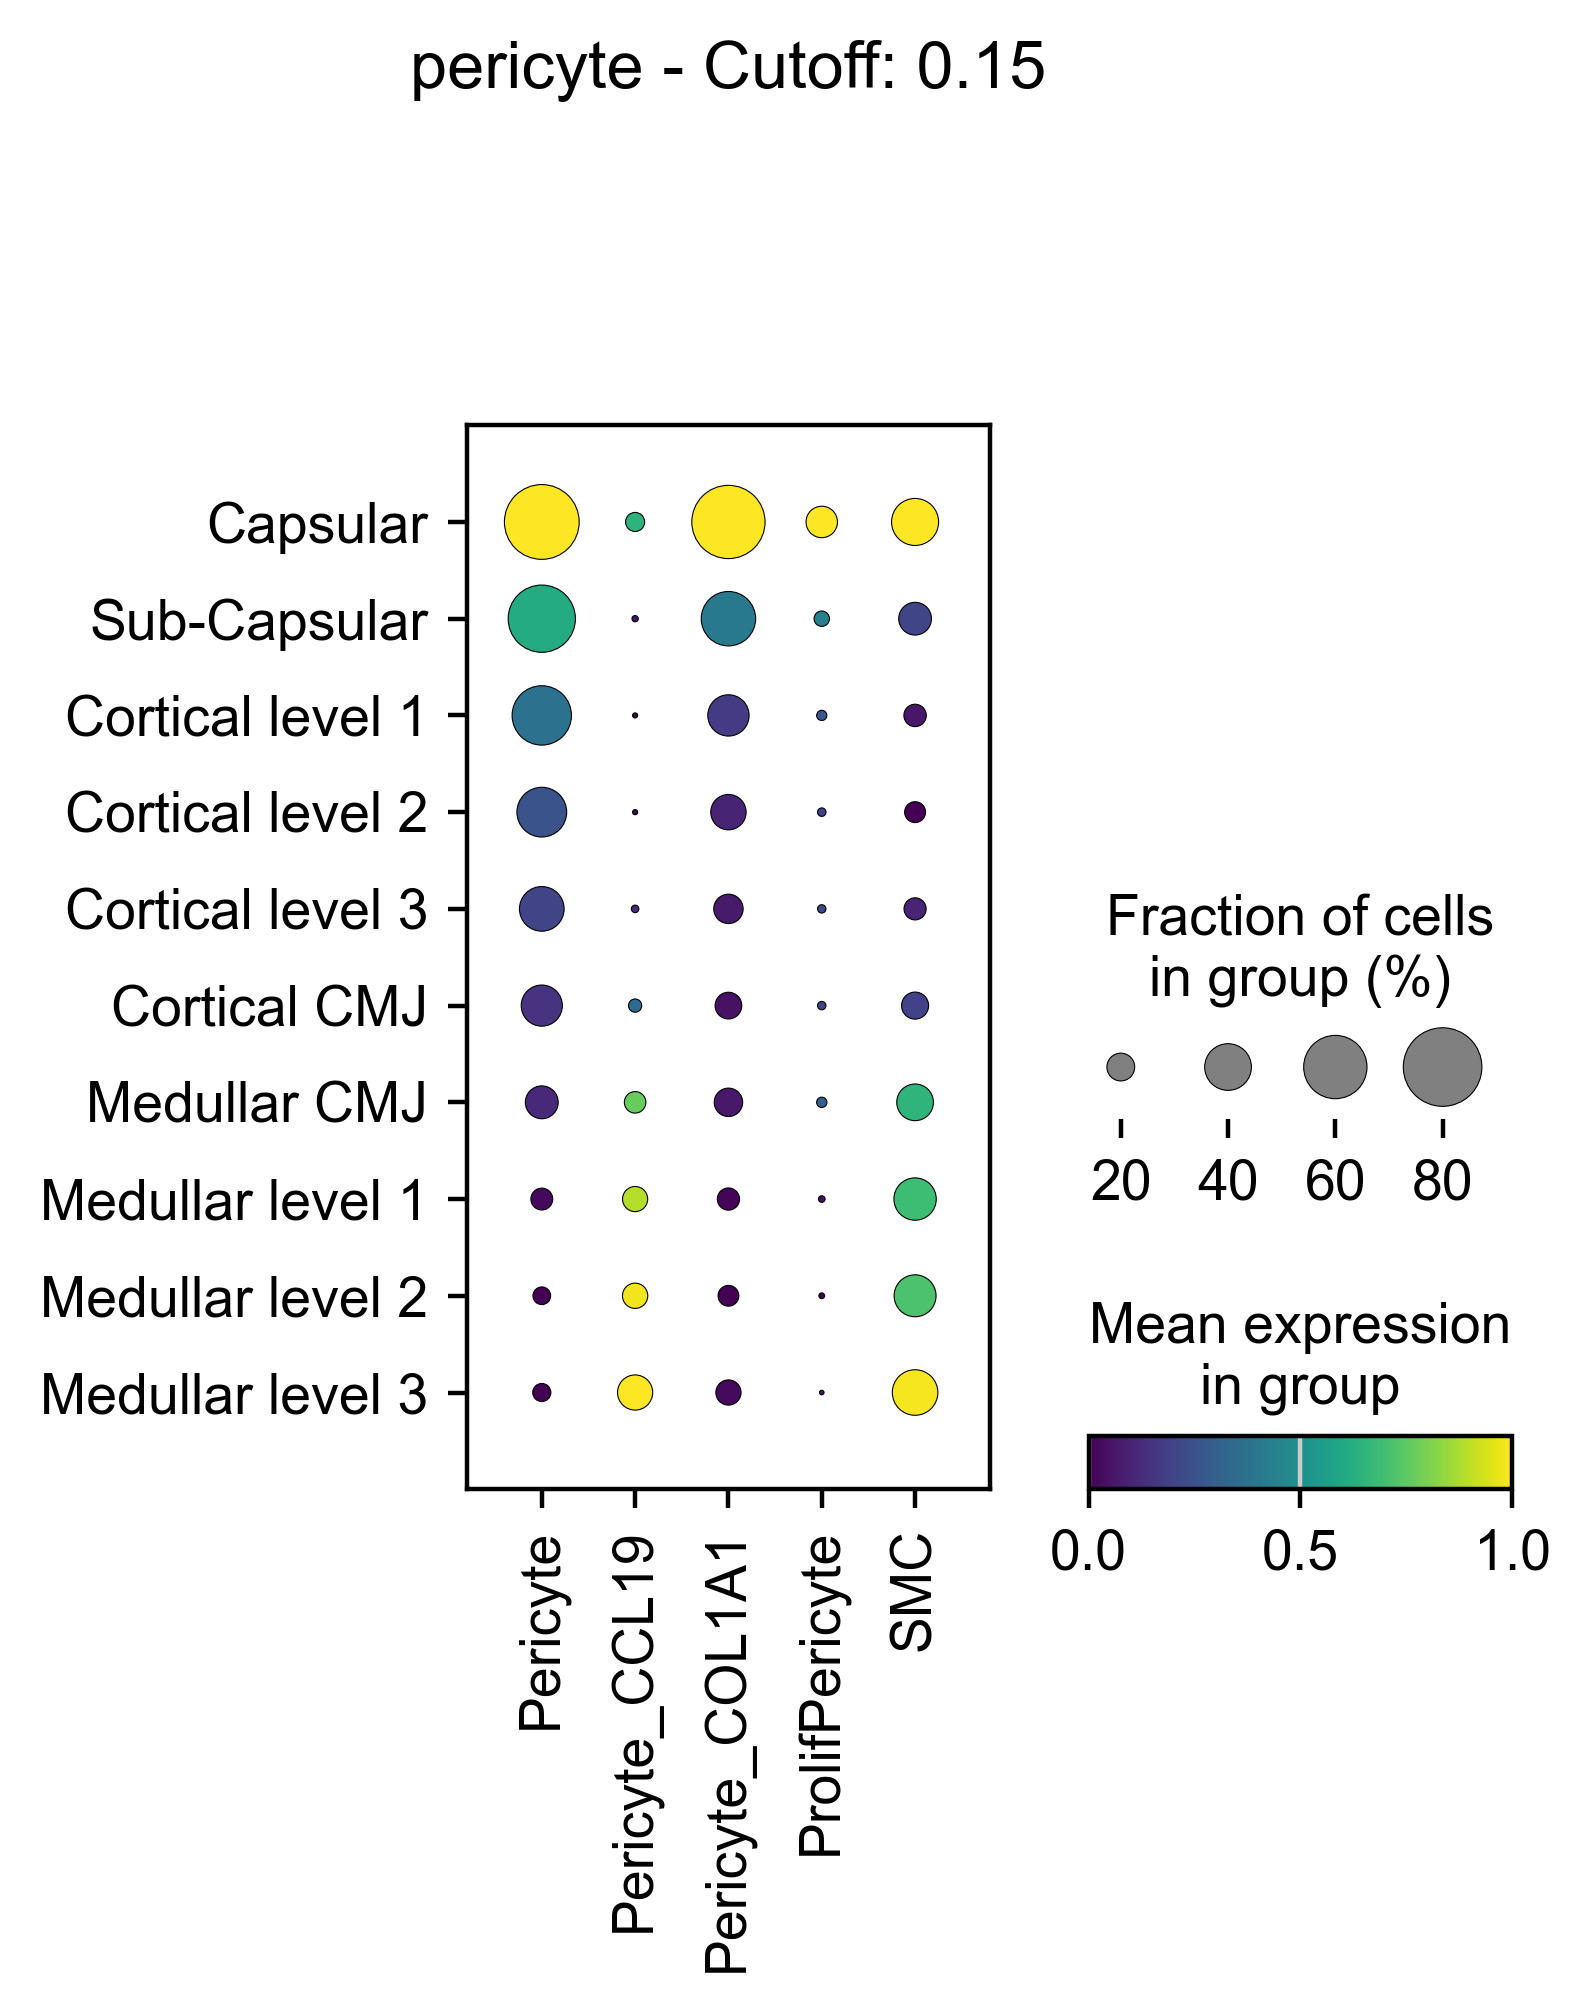

In [16]:
# subset cells supplemnetary FB figure 
os.chdir('/nfs/team205/ny1/ThymusSpatialAtlas/Figure_3_nat/')

subset_keys = ['FB','EC','pericyte']
cutoff = {'FB':0.15,'EC':0.15,'pericyte':0.15}
cells_subset = {k: cells[k] for k in subset_keys}
 
sc.set_figure_params(figsize=[7, 7], fontsize=12, dpi=200)

for cell, cell_types in cells_subset.items():
    print(cell)
    print(cell_types)
    save_path = f'fet_{cell}_cutoff_{cutoff[cell]}.pdf'  # Construct the file name
    dp = sc.pl.dotplot(cellab_fet, var_names=cell_types,
              groupby='manual_bin_cma_v2', cmap='viridis',title=f'{cell} - Cutoff: {cutoff[cell]}',
                      expression_cutoff=cutoff[cell], standard_scale='var', return_fig = True)#save=save_path)
    export_Source_dotplot(Dotplot_obj = dp, path = source_folder, name = f"{cell}_{cutoff[cell]}_fetal_Visdotplot_source_data")
    dp.show()